In [1]:
import os
import fnmatch
import itertools
import numpy as np
from numpy import linalg as LA
from vpython import *

import matplotlib.pyplot as plt # after importting matplotlib, mayavi can not set api to 2: first run mayavi!!!!
import matplotlib as mpl
from latexify import latexify
#latexify()
#mpl.style.use('classic')
%matplotlib notebook

<IPython.core.display.Javascript object>

In [2]:
def my_vector(a_list):
    return vector(a_list[0],a_list[1],a_list[2])

# Define functions

In [6]:
# Functions loading one spins file
def load_atpos_bonds(file, nAtomCell=16):
    atpos=np.zeros([nAtomCell,3]) #store the atom positions in a unit cell
    bonds = np.zeros([6,1000])#store the 30 bonds in the unitCell: atom1,atom2,pos[a2]-pos[a1]
    
    # Read the atom positions in a unit cell
    with open(file, 'r') as f:
        i=0
        for line in f:
            line=line.rstrip('\n').split()# without giving delimenter, it will treat conseutive space as one
            if line[0]=="SITE":
                atpos[i,:]=line[1:]#automatically convert string to np.array
                i=i+1
            if i>= nAtomCell:
                break
                
    ##### find the nearest Gd-Gd neighbers within a unit cell  
    idx = 0
    for i in np.arange(0,len(atpos)-1,1):
        for ii in np.arange(i+1,len(atpos),1):
            dist = LA.norm(atpos[i]-atpos[ii])
            bonds[:,idx] = np.append(np.append(np.array([i, ii]),atpos[ii]-atpos[i]),dist)
            idx +=1
    bonds = bonds[:5, bonds[5,:]==np.min(bonds[5, np.nonzero(bonds[5,:]) ])]
    
    return atpos, bonds
    
def load_spins(file, nAtomCell=16, SC=[6,6,6], calPolF=True, physType='iceIsing'):
    spins=np.zeros(np.hstack([SC,nAtomCell,3]))#store the spins in a supercell
    if calPolF:
        polF = np.zeros(np.hstack([SC,nAtomCell,9]))
        # Local [111] axes for the 16 atoms
        aniso = np.array([[1,1,1],[1,1,1],[1,1,1],[1,1,1],
                          [1,-1,-1],[1,-1,-1],[1,-1,-1],[1,-1,-1],
                          [-1,1,-1],[-1,1,-1],[-1,1,-1],[-1,1,-1],
                          [-1,-1,1],[-1,-1,1],[-1,-1,1],[-1,-1,1]])/np.sqrt(3.)
        
    # Read all the spin orientations with doing Sx*local11,Sy*local11,Sz*local11
    with open(file, 'r') as f:
        for line in f:
            line=line.rstrip('\n').split()# without giving delimenter, it will treat conseutive space as one
            if line[0]=="SPIN":
                idxUC=np.array(line[1:5],dtype='int32')# atom index 1-16, SuperCell idx [i,j,k]
                Sxyz = np.array(line[5:8],dtype='float') # spin orientatoins
                #print(idxUC)
                spins[idxUC[1],idxUC[2],idxUC[3],idxUC[0]-1,:] = Sxyz
                if calPolF:                   
                    if physType == 'Heisenberg':
                        # For Heisenberg: Sx*local,Sy*local,Sz*local
                        polF[idxUC[1],idxUC[2],idxUC[3],idxUC[0]-1,:]= \
                                          np.hstack([Sxyz[0]*aniso[idxUC[0]-1,:],
                                                     Sxyz[1]*aniso[idxUC[0]-1,:],
                                                     Sxyz[2]*aniso[idxUC[0]-1,:]])
                    elif physType == 'iceIsing':
                        # For Spin ice: only the for 3 elements is needed Si*localZ_i=+/-1 * localZ_i,  
                        # the rest is not used!
                        polF[idxUC[1],idxUC[2],idxUC[3],idxUC[0]-1,:]= \
                             np.hstack([(Sxyz   @aniso[idxUC[0]-1,:])*aniso[idxUC[0]-1,:],
                                         Sxyz[1]*aniso[idxUC[0]-1,:],
                                         Sxyz[2]*aniso[idxUC[0]-1,:]])
                    else: 
                        print('which type of spins: iceIsing or Heisenberg')
    if calPolF:
        return spins, polF
    else:
        return spins
    
def batch_load_spins(fpath, fname_pattern, nSC=1, nAtomCell=16, SC=[6,6,6], calPolF=True, physType='iceIsing'):
    """
    Return:
        atpos: [nAtomCell, 3]
        bonds: [6, nb_of_nnBonds] (col: idxAtom1, idxAtom2, posAtom2-posAtom1) within unit cell
        spins: [nSC, SC[0], SC[1], SC[2], nAtomCell, 3]
        polF:  [nSC, SC[0], SC[1], SC[2], nAtomCell, 9]
    """
    spins = np.empty(np.hstack([nSC, SC, nAtomCell,3]))
    if calPolF:
        polF  = np.empty(np.hstack([nSC, SC, nAtomCell,9]))
    idx = 0
    #print(os.listdir(fpath))
    for file in os.listdir(fpath):
        if fnmatch.fnmatch(file, fname_pattern):   
            print(file)
            if idx==0:
                atpos, bonds = load_atpos_bonds(os.path.join(fpath,file), nAtomCell)
            if calPolF:
                spins[idx], polF[idx] = \
                    load_spins(os.path.join(fpath,file), nAtomCell, SC, calPolF=True, physType=physType)
                idx += 1
            else:
                spins[idx] = \
                    load_spins(os.path.join(fpath,file), nAtomCell, SC, calPolF=False, physType=physType)
                idx += 1
    if calPolF:
        return atpos, bonds, spins, polF
    else:
        return atpos, bonds, spins
    
# Functions plot randomly a UC with spins and bonds    
def plot_rand_UC(atpos, spins, bonds, o8b=None, polF_av_nd=None, SC=[6,6,6], wch_cell=None, spinl0 = 0.2,spinl1=0.2, atomr = 0.5, cylr = 0.005):
    """
    atpos: nAtomCell by 3
    spins: [SC[0], SC[1], SC[2], nAtomCell, 3]
    bonds: [6, nb_of_nnBonds] (col: idxAtom1, idxAtom2, posAtom2-posAtom1) within unit cell
    SC   : dimension of the super cell
    """
    scene = canvas(title='MagStr', width=1000, height=1000,x=500,y=500,center=my_vector((0.5,0.5,0.5)),
                     background=color.black,exit=False)
    scene.autocenter = True # why not working
    scene.autoscale = True 
    if wch_cell is None:
        wch_cell = np.random.randint(0,SC[0],3)
    print('Unit Cell:', wch_cell)
    # Plot the Gd atoms, easy axes and the bonds
    for i in range(len(atpos)):
        spin = spins[wch_cell[0],wch_cell[1],wch_cell[2],i,:]
        arrow(pos=my_vector(atpos[i]-spinl0*spin/2), axis=my_vector(spinl0*spin),shaftwidth=0.01) # spin
        sphere(pos=my_vector(atpos[i]), color=color.orange, radius=atomr*0.05) # atoms
        label(pos=my_vector(atpos[i]+(0,0,0.1)), text=str(i%16))    

    for i in range(bonds.shape[1]):
        cylinder(pos=my_vector(atpos[int(bonds[0,i])]), axis=my_vector(bonds[2:,i]), radius=cylr)
    
    if o8b is not None:
        if polF_av_nd is not None:
            # Plot the O atoms #and the surrouding Gd (slightly shfited along local 111, to compare with the Gd)
            hsv = my_vector((0.6667+i*0.333/8,1,0.5))
            for i in range(len(o8b)-3):
                pol = polF_av_nd[wch_cell[0],wch_cell[1],wch_cell[2],i, 0:3]*2# 0:3 for Px
                sphere(pos=my_vector(o8b[i]), color=color.hsv_to_rgb(hsv),radius=atomr*0.1) # color: blue-red
                arrow(pos=my_vector(o8b[i]-spinl1*pol/2), axis=my_vector(spinl1*pol),shaftwidth=0.01,color=color.white) # polarization
                around = orBonds[orBonds[:,0]==i]
                
# Save
def save_diamondPolF(file, polF_av, SC=[6,6,6]):
    """
    polF_av: 8*6**3 by 7
    only saved Px
    """
    o8b = np.array([ [ 0.625,  0.625,  0.625],
                 [ 0.625,  0.125,  0.125],
                 [ 0.125,  0.125,  0.625],
                 [ 0.125,  0.625,  0.125],
                 [ 0.375,  0.375,  0.375],
                 [ 0.375,  0.875,  0.875],
                 [ 0.875,  0.375,  0.875],
                 [ 0.875,  0.875,  0.375]])
    
    # Save super lattice
    f = open(file, 'w+') # append
    f.write('TITLE spin \n')
    f.write('CELL 10.440 10.440 10.440 90.00 90.00 90.00\n')

    names  = np.repeat('SITE',8)
    outputs = map(lambda x: "%s  %f %f %f " % (x[0],x[1][0],x[1][1],x[1][2]),
                  zip(names,o8b)) 
    data = '\n'.join(outputs)+'\n' # Concat all strings in list, separated by line break
    f.write(data)

    f.write('BOX 6 6 6\nFORM_FACTOR_J0 0 0 0\nPROPOSED_MOVES 0\nACCEPTED_MOVES 0\nWEIGHT 3\nCHI_SQUARED 14\nR_FACTOR 3.4\nSCALE 72\nFLAT_BACKGROUND 0.0\nLINEAR_BACKGROUND 0\n')

    names  = np.repeat('SPIN',8*np.prod(SC)).astype('str')
    outputs = map(lambda x: "%s %i %i %i %i %f %f %f " % (x[0],x[1][0],x[1][1],x[1][2],x[1][3],x[1][4],x[1][5],x[1][6]),
                  zip(names, polF_av)) 
    data = '\n'.join(outputs) # Concat all strings in list, separated by line break
    f.write(data)
    f.close()
    print('Saved ' + file)
    
# Create diamond or o8b superlattice
def diamond_pTensor(polF, orBonds=None, SC=[6,6,6], save=False, fpath=r'\D:', fname_pattern='diamond_'):
    """
    polF: nd array with dim: [nSC, SC[0], SC[1], SC[2], nAtomCell, 9]   
    orBonds: O-R bonds in a unit cell, 32 by 8, (row: idx_O, idx_R, dLx, dLy, dLz, drx, dry, drz)
    Return:
        polF_av: averaged on tetrahedra
        polF_av_nd: polF_av with super cell as indices
    """
    if orBonds is None: 
        orBonds =np.array([[ 0,  0,  0,  0,  0, -0.125, -0.125, -0.125],
                           [ 0,  4,  0,  0,  0, -0.125,  0.125,  0.125],
                           [ 0,  8,  0,  0,  0,  0.125, -0.125,  0.125],
                           [ 0, 13,  0,  0,  0,  0.125,  0.125, -0.125],
                           [ 1,  1,  0,  0,  0, -0.125, -0.125, -0.125],
                           [ 1,  5,  0,  0,  0, -0.125,  0.125,  0.125],
                           [ 1,  9,  0,  0,  0,  0.125, -0.125,  0.125],
                           [ 1, 12,  0,  0,  0,  0.125,  0.125, -0.125],
                           [ 2,  2,  0,  0,  0, -0.125, -0.125, -0.125],
                           [ 2,  6,  0,  0,  0, -0.125,  0.125,  0.125],
                           [ 2, 10,  0,  0,  0,  0.125, -0.125,  0.125],
                           [ 2, 15,  0,  0,  0,  0.125,  0.125, -0.125],
                           [ 3,  3,  0,  0,  0, -0.125, -0.125, -0.125],
                           [ 3,  7,  0,  0,  0, -0.125,  0.125,  0.125],
                           [ 3, 11,  0,  0,  0,  0.125, -0.125,  0.125],
                           [ 3, 14,  0,  0,  0,  0.125,  0.125, -0.125],
                           [ 4,  0,  0,  0,  0,  0.125,  0.125,  0.125],
                           [ 4,  5,  0,  0,  0,  0.125, -0.125, -0.125],
                           [ 4, 11,  0,  0,  0, -0.125,  0.125, -0.125],
                           [ 4, 15,  0,  0,  0, -0.125, -0.125,  0.125],
                           [ 5,  4,  0,  0,  0,  0.125, -0.125, -0.125],
                           [ 5, 14,  0,  0,  1, -0.125, -0.125,  0.125],
                           [ 5, 10,  0,  1,  0, -0.125,  0.125, -0.125],
                           [ 5,  1,  0,  1,  1,  0.125,  0.125,  0.125],
                           [ 6,  8,  0,  0,  0, -0.125,  0.125, -0.125],
                           [ 6, 12,  0,  0,  1, -0.125, -0.125,  0.125],
                           [ 6,  6,  1,  0,  0,  0.125, -0.125, -0.125],
                           [ 6,  3,  1,  0,  1,  0.125,  0.125,  0.125],
                           [ 7, 13,  0,  0,  0, -0.125, -0.125,  0.125],
                           [ 7,  9,  0,  1,  0, -0.125,  0.125, -0.125],
                           [ 7,  7,  1,  0,  0,  0.125, -0.125, -0.125],
                           [ 7,  2,  1,  1,  0,  0.125,  0.125,  0.125]])
    if polF.ndim == 5:
        nSC = 1
    elif polF.ndim == 6:
        nSC = polF.shape[0]
        print(nSC)
    else:
        print('wrong input')
        return
    
    polF_av = np.zeros([nSC, 8*np.prod(SC), 13]) #13: atIdx 0-8, cell index Lx,Ly,Lz, Px(xyz), Py, Pz
    polF_av_nd = np.zeros(np.hstack([nSC, SC, 8, 9])) # 8 O8b in a unit cell

    for iSC in range(nSC):
        idx = 0
        for i in range(SC[0]):
            for j in range(SC[1]):
                for k in range(SC[2]):
                    for l in np.arange(0,8):
                        tetra = np.array(orBonds[orBonds[:,0]==l,1:5],dtype='int32')
                        #print(tetra)
                        idxCell = np.array([i,j,k] + tetra[:,1:4])
                        idxCell = np.where(idxCell==6,0,idxCell)
                        #print(idxCell)
                        # 0:3 for Px, 3:6 for Py, 6 :9 for Pz
                        try: #polF is possibly without the nSC axis
                            sumTetra = polF[idxCell[:,0],idxCell[:,1],idxCell[:,2],tetra[:,0],0:9].mean(axis=0)
                            polF_av[iSC, idx, :] = np.hstack((np.array([l+1,i,j,k]),sumTetra))
                            polF_av_nd[iSC,i,j,k,l,:] = sumTetra
                            idx +=1
                        except:
                            sumTetra = polF[iSC,idxCell[:,0],idxCell[:,1],idxCell[:,2],tetra[:,0],0:9].mean(axis=0)
                            polF_av[iSC, idx, :] = np.hstack((np.array([l+1,i,j,k]),sumTetra))
                            polF_av_nd[iSC, i,j,k,l,:] = sumTetra
                            idx +=1
        if save:
            file = os.path.join(fpath, fname_pattern+"{:02d}".format(iSC+1)+'.txt')
            save_diamondPolF(file, np.squeeze(polF_av[iSC]))
    return polF_av, polF_av_nd



# Find the neigbors of oxygen ions on the first unit cell
# create a 333 supercell and search neighbor for the O ions in the centeral cell
atpos = np.array([
    [0.5,  0.5,  0.5 ],
    [0.5,  0.,   0.  ],
    [0.,   0.,   0.5 ],
    [0.,   0.5,  0.  ],
    [0.5,  0.75, 0.75],
    [0.5,  0.25, 0.25],
    [0.,   0.25, 0.75],
    [0.,   0.75, 0.25],
    [0.75, 0.5,  0.75],
    [0.75, 0.,   0.25],
    [0.25, 0.,   0.75],
    [0.25, 0.5,  0.25],
    [0.75, 0.25, 0.  ],
    [0.75, 0.75, 0.5 ],
    [0.25, 0.75, 0.  ],
    [0.25, 0.25, 0.5 ]])

aniso = np.array([[1,1,1],[1,1,1],[1,1,1],[1,1,1],
                  [1,-1,-1],[1,-1,-1],[1,-1,-1],[1,-1,-1],
                  [-1,1,-1],[-1,1,-1],[-1,1,-1],[-1,1,-1],
                  [-1,-1,1],[-1,-1,1],[-1,-1,1],[-1,-1,1]])/np.sqrt(3.)

# Diamond lattic: center of the tetrahedra (5) + and three from O+0.25[111] (first 4: type A, last 4: type B)
o8b = np.array([ [ 0.625,  0.625,  0.625],
                 [ 0.625,  0.125,  0.125],
                 [ 0.125,  0.125,  0.625],
                 [ 0.125,  0.625,  0.125],
                 [ 0.375,  0.375,  0.375],
                 [ 0.375,  0.875,  0.875],
                 [ 0.875,  0.375,  0.875],
                 [ 0.875,  0.875,  0.375]])

permu=np.array(list(itertools.product([0,1,-1], repeat=3) ) )
allpos = np.vstack([atpos+item for item in permu])

orBondsIdx = np.zeros([32,2],dtype=int) #store the 32 R-O(8b) bonds in the unitCell: idx(O8b),idx(R),
orBonds = np.zeros([32,8])#store the 32 R-O(8b) bonds in the unitCell: idx(O8b),idx(R), dL, pos[a2]-pos[a1]
idx = 0
for i in np.arange(0,len(o8b),1):
    for ii in np.arange(0,len(allpos),1):
        distance = LA.norm(o8b[i]-allpos[ii])
        if distance==np.sqrt(3/64.):
            ridx = np.remainder(ii,16)
            orBondsIdx[idx,:] = [i*1., ridx]
            orBonds[idx,:]=np.hstack( [ [i,ridx], np.trunc(allpos[ii]), allpos[ii]-o8b[i] ] )
            idx +=  1

#print(orBondsIdx)
#print(orBonds)
#print(repr(orBonds)) # print array with commas

In [8]:
# Load one spins file
fpath = r'D:\2_Neutron_scattering\0_SpinVert\0_spinvert_program\spinvert_with_modifed\examples\spinice/'
fname = 'spinice_spins_01.txt'

fpath1 = r'D:/2_Neutron_scattering\0_SpinVert\gdhfo_d7/35mK\pc_correlations/'
fname1 = r'pc_spins_01.txt'

file = os.path.join(fpath1,fname1)
#file = r'D:\2_Neutron_scattering\0_SpinVert\gdzro_ill\gd_ill_60mk-20k_with_paramag\diamond_correlations\diamond_Px_spinice_spins_01.txt'

# atpos, bonds, spins = \
#                 load_spins(file, nAtomCell=16, SC=[6,6,6], calPolF=False, physType='iceIsing')

atpos, bonds = load_atpos_bonds(file, nAtomCell=16)
spins, polF = load_spins(file, nAtomCell=16, SC=[6,6,6], calPolF=True, physType='Heisenberg')

print(atpos)
print(bonds.T)
print(spins.shape)
print(polF.shape)

plot_rand_UC(atpos, spins, bonds, SC=[6,6,6], wch_cell=[0,0,0], spinl0=0.2,spinl1=0.1)

[[0.5  0.5  0.5 ]
 [0.5  0.   0.  ]
 [0.   0.   0.5 ]
 [0.   0.5  0.  ]
 [0.5  0.75 0.75]
 [0.5  0.25 0.25]
 [0.   0.25 0.75]
 [0.   0.75 0.25]
 [0.75 0.5  0.75]
 [0.75 0.   0.25]
 [0.25 0.   0.75]
 [0.25 0.5  0.25]
 [0.75 0.25 0.  ]
 [0.75 0.75 0.5 ]
 [0.25 0.75 0.  ]
 [0.25 0.25 0.5 ]]
[[ 0.    4.    0.    0.25  0.25]
 [ 0.    5.    0.   -0.25 -0.25]
 [ 0.    8.    0.25  0.    0.25]
 [ 0.   11.   -0.25  0.   -0.25]
 [ 0.   13.    0.25  0.25  0.  ]
 [ 0.   15.   -0.25 -0.25  0.  ]
 [ 1.    5.    0.    0.25  0.25]
 [ 1.    9.    0.25  0.    0.25]
 [ 1.   12.    0.25  0.25  0.  ]
 [ 2.    6.    0.    0.25  0.25]
 [ 2.   10.    0.25  0.    0.25]
 [ 2.   15.    0.25  0.25  0.  ]
 [ 3.    7.    0.    0.25  0.25]
 [ 3.   11.    0.25  0.    0.25]
 [ 3.   14.    0.25  0.25  0.  ]
 [ 4.    8.    0.25 -0.25  0.  ]
 [ 4.   13.    0.25  0.   -0.25]
 [ 5.    9.    0.25 -0.25  0.  ]
 [ 5.   11.   -0.25  0.25  0.  ]
 [ 5.   12.    0.25  0.   -0.25]
 [ 5.   15.   -0.25  0.    0.25]
 [ 6.   10.    0.2

<IPython.core.display.Javascript object>

Unit Cell: [0, 0, 0]


In [5]:
# Batch loading
fpath = r'D:\2_Neutron_scattering\0_SpinVert\0_spinvert_program\spinvert_with_modifed\examples\spinice/'
fname = 'spinice_spins_*.txt'

atpos, bonds, spins, polF = \
    batch_load_spins(fpath, fname, nSC=12, nAtomCell=16, SC=[6,6,6], calPolF=True, physType='iceIsing')

spinice_spins_01.txt
spinice_spins_02.txt
spinice_spins_03.txt
spinice_spins_04.txt
spinice_spins_05.txt
spinice_spins_06.txt
spinice_spins_07.txt
spinice_spins_08.txt
spinice_spins_09.txt
spinice_spins_10.txt
spinice_spins_11.txt
spinice_spins_12.txt


In [6]:
# GZO
fpath = r'D:\2_Neutron_scattering\0_SpinVert\gdzro_ill\gd_ill_60mk-20k_with_paramag'
fname = '10k_0p994_s3_wl2p41_p3500i_spins_*.txt'
fname = 'diamond_part_spins_*.txt'
atpos, bonds, spins = \
    batch_load_spins(fpath, fname, nSC=40, nAtomCell=16, SC=[6,6,6], calPolF=False)

print(atpos, bonds)
print(spins.shape)
#print(polF.shape)

diamond_part_spins_01.txt
diamond_part_spins_02.txt
diamond_part_spins_03.txt
diamond_part_spins_04.txt
diamond_part_spins_05.txt
[[0.625 0.625 0.625]
 [0.625 0.125 0.125]
 [0.125 0.125 0.625]
 [0.125 0.625 0.125]
 [0.375 0.375 0.375]
 [0.375 0.875 0.875]
 [0.875 0.375 0.875]
 [0.875 0.875 0.375]
 [0.    0.    0.   ]
 [0.    0.    0.   ]
 [0.    0.    0.   ]
 [0.    0.    0.   ]
 [0.    0.    0.   ]
 [0.    0.    0.   ]
 [0.    0.    0.   ]
 [0.    0.    0.   ]] [[ 0.    0.    0.    0.    1.    2.    3.  ]
 [ 4.    5.    6.    7.    4.    4.    4.  ]
 [-0.25 -0.25  0.25  0.25 -0.25  0.25  0.25]
 [-0.25  0.25 -0.25  0.25  0.25  0.25 -0.25]
 [-0.25  0.25  0.25 -0.25  0.25 -0.25  0.25]]
(40, 6, 6, 6, 16, 3)


In [7]:
# GHO: domain correlatoins
fpath=r'D:\2_neutron_scattering\0_SpinVert\gdhfo_d7\35mK/'

fname='35mk_spins_*.txt'
atpos, bonds, spins = \
    batch_load_spins(fpath, fname, nSC=40, nAtomCell=16, SC=[6,6,6], calPolF=False)
fname='diamond_part_hard_spins_*.txt'
_, _, spins_diamond = \
    batch_load_spins(fpath, fname, nSC=40, nAtomCell=8, SC=[5,5,5], calPolF=False)
print(atpos, bonds)
print(spins.shape)
#print(polF.shape)

35mk_spins_01.txt
35mk_spins_02.txt
35mk_spins_03.txt
35mk_spins_04.txt
35mk_spins_05.txt
35mk_spins_06.txt
35mk_spins_07.txt
35mk_spins_08.txt
35mk_spins_09.txt
35mk_spins_10.txt
35mk_spins_11.txt
35mk_spins_12.txt
35mk_spins_13.txt
35mk_spins_14.txt
35mk_spins_15.txt
35mk_spins_16.txt
35mk_spins_17.txt
35mk_spins_18.txt
35mk_spins_19.txt
35mk_spins_20.txt
35mk_spins_21.txt
35mk_spins_22.txt
35mk_spins_23.txt
35mk_spins_24.txt
35mk_spins_25.txt
35mk_spins_26.txt
35mk_spins_27.txt
35mk_spins_28.txt
35mk_spins_29.txt
35mk_spins_30.txt
35mk_spins_31.txt
35mk_spins_32.txt
35mk_spins_33.txt
35mk_spins_34.txt
35mk_spins_35.txt
35mk_spins_36.txt
35mk_spins_37.txt
35mk_spins_38.txt
35mk_spins_39.txt
35mk_spins_40.txt
diamond_part_hard_spins_01.txt
diamond_part_hard_spins_02.txt
diamond_part_hard_spins_03.txt
diamond_part_hard_spins_04.txt
diamond_part_hard_spins_05.txt
diamond_part_hard_spins_06.txt
diamond_part_hard_spins_07.txt
diamond_part_hard_spins_08.txt
diamond_part_hard_spins_09.txt
d

In [8]:
print(spins[0,0,0,0,0:16,:])
print(polF[0,0,0,0,0:16,0:3])
print(np.allclose(spins[11,0,0,0,0:16,:],polF[11,0,0,0,0:16,0:3]))

[[ 0.02196706  0.70427026  0.70959203]
 [-0.63147754  0.49546376  0.59644931]
 [ 0.71406973 -0.36717491 -0.59605956]
 [-0.50399464  0.14987903  0.85060313]
 [-0.63757824  0.74489972  0.19651565]
 [ 0.73026162  0.13628125  0.66943662]
 [-0.88702426 -0.41339282  0.20565589]
 [ 0.49717382  0.10016878 -0.86184941]
 [ 0.15580368 -0.04771603 -0.98663488]
 [ 0.42529216 -0.54280383 -0.72421722]
 [ 0.20179856  0.96515156  0.16661274]
 [ 0.59113422 -0.55233714 -0.58777889]
 [-0.29261238 -0.84770139 -0.44247073]
 [ 0.14114706 -0.67578572 -0.72345778]
 [-0.43933334  0.10381065 -0.89230576]
 [-0.95988577  0.28008095  0.0131898 ]]
[[-0.57735027 -0.57735027 -0.57735027]
 [-0.57735027 -0.57735027 -0.57735027]
 [ 0.57735027  0.57735027  0.57735027]
 [ 0.57735027  0.57735027  0.57735027]
 [-0.57735027  0.57735027  0.57735027]
 [ 0.57735027 -0.57735027 -0.57735027]
 [-0.57735027  0.57735027  0.57735027]
 [-0.57735027  0.57735027  0.57735027]
 [-0.57735027  0.57735027 -0.57735027]
 [-0.57735027  0.5773502

In [123]:
# Calculate polarization field
polF_av, polF_av_nd = diamond_pTensor(polF, SC=[6,6,6], save=False, fpath=fpath, fname_pattern='diamond_spins_')

12


In [11]:
# Polt a randomly a unit cell with spins
#plot_rand_UC(atpos, spins[0], bonds, o8b=o8b, polF_av_nd=polF_av_nd[0], SC=[6,6,6], wch_cell=None, spinl=0.25)
plot_rand_UC(atpos, spins[0], bonds, o8b=o8b, polF_av_nd=spins_diamond[0], SC=[6,6,6], wch_cell=[0,0,0], spinl0=0.2,spinl1=0.1)
#plot_rand_UC(atpos, spins[4], bonds, o8b=None, polF_av_nd=None, SC=[5,5,5], wch_cell=None, spinl=0.25)

<IPython.core.display.Javascript object>

Unit Cell: [0, 0, 0]


C:\Users\jxu\AppData\Local\Temp/ipykernel_13704/1730085231.py:122: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cylinder(pos=my_vector(atpos[np.int(bonds[0,i])]), axis=my_vector(bonds[2:,i]), radius=cylr)


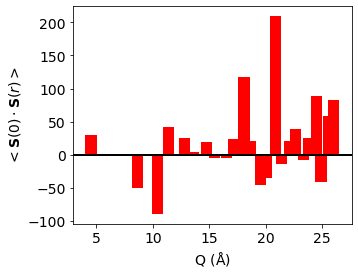

In [87]:
path = r'D:\2_Neutron_scattering\0_SpinVert\gdzro_ill\gd_ill_60mk-20k_with_paramag\diamond_correlations\a0_scf.txt'
path = r'D:\2_Neutron_scattering\0_SpinVert\gdzro_ill\gd_ill_60mk-20k_with_paramag\diamond_correlations\diamond_Px_spinice_scf.txt'
path = r'D:\2_Neutron_scattering\0_SpinVert\0_spinvert_program\spinvert_with_modifed\examples\spinice\spinice_diamond_scf1.txt'
path = r'D:\2_Neutron_scattering\0_SpinVert\gdzro_ill\gd_ill_60mk-20k_with_paramag\diamond_part_scf.txt'

scf = np.genfromtxt(path, dtype=None, skip_header=0,delimiter=None)
fig, ax = plt.subplots(figsize=(5,4))
ax.bar(scf[:,0],scf[:,1]*scf[:,0]**3, width=1, color='r')
#ax.bar(scf[:,0],scf[:,1], width=1, color='r')
plt.axhline(0, color='black', lw=2)
plt.xticks(color='k', size=14)
plt.yticks(color='k', size=14)    
plt.ylabel(r'$<{\bf S}(0)\cdot{\bf S}(r)>$',size=14)
plt.xlabel(r"$\rm Q\ (\AA)$",size=14)
plt.show()

In [65]:
data = np.genfromtxt(path, dtype=None, skip_header=0,delimiter=None)
print(data)
mask1 = data[:,1] >=0
mask2 = data[:,1] < 0

from ipywidgets import interact,FloatSlider
x=np.linspace(0.4,35,100)

amplitude_slider1 = FloatSlider(min=1, max=10, step=0.1, value=3.7)
amplitude_slider2 = FloatSlider(min=1, max=10, step=1, value=3)
@interact(r1=amplitude_slider1, r2=amplitude_slider2)
def pltc(r1,r2):
    fig, ax = plt.subplots(figsize=(5, 4))#,subplot_kw={'axisbg':'#EEEEEE','axisbelow':True})
    #ax.plot(data[:,0],np.absolute(data[:,1]),color='black',linewidth=1)
    ax.bar(data[mask1,0],np.absolute(data[mask1,1]), width=1, label='Positive')
    ax.bar(data[mask2,0],np.absolute(data[mask2,1]), width=1, label='Negative')
    ax.plot(x,np.exp(-x/r1),label=r'$\exp\left(-\frac{r}{%1.2f}\right)$' % r1,c='g')
    #ax.plot(x,r2/x**3,label=r'${:2.1f}/r^3$'.format(r2),c='black')
    ax.set_ylim(0,0.4)

    plt.minorticks_on()
    plt.xticks(color='k', size=14)
    plt.yticks(color='k', size=14)
    
    plt.ylabel(r'$|<{\bf S}(0)\cdot{\bf S}(r)>|$',size=14)
    plt.xlabel(r"$r\ \rm(\AA)$",size=14)
    
    handles, labels = ax.get_legend_handles_labels()
#    ax.legend([handles[2],handles[3],handles[0],handles[1]], 
#              [labels[2],labels[3],labels[0],labels[1]],frameon=False,framealpha=1,fontsize=14)
    ax.legend([handles[1],handles[2],handles[0]], 
              [labels[1],labels[2],labels[0]],frameon=False,framealpha=1,fontsize=14)
    
    plt.draw()
    plt.show()
    #fig.savefig(fname.replace('txt','pdf'), bbox_inches="tight",verbose=True)  

[[ 4.52070000e+00  3.15780686e-01  5.45791933e-03]
 [ 7.38220000e+00 -2.65052891e-03  3.14357137e-03]
 [ 8.65640000e+00 -7.79196695e-02  3.26071573e-03]
 [ 1.04400000e+01 -7.86052184e-02  4.69569622e-03]
 [ 1.13767000e+01  2.81690011e-02  3.29876330e-03]
 [ 1.27863000e+01  1.20552309e-02  2.22976421e-03]
 [ 1.35620000e+01  1.78188984e-03  2.90694203e-03]
 [ 1.47644000e+01  6.16903815e-03  3.37945409e-03]
 [ 1.54410000e+01 -1.41835307e-03  2.40100687e-03]
 [ 1.65071000e+01 -1.09966577e-03  2.34089120e-03]
 [ 1.71149000e+01  4.86880792e-03  3.41880486e-03]
 [ 1.80826000e+01  1.99626460e-02  4.17247371e-03]
 [ 1.86391000e+01  3.20252487e-03  2.43911505e-03]
 [ 1.95315000e+01 -6.07095606e-03  1.67678858e-03]
 [ 2.00478000e+01 -4.38029318e-03  1.93242387e-03]
 [ 2.08800000e+01  2.29799063e-02  4.59164864e-03]
 [ 2.13638000e+01 -1.50139878e-03  3.36674867e-03]
 [ 2.21466000e+01  1.85278148e-03  1.86931229e-03]
 [ 2.26033000e+01  3.37987649e-03  2.19008123e-03]
 [ 2.33445000e+01 -6.47561427e-

interactive(children=(FloatSlider(value=3.7, description='r1', max=10.0, min=1.0), FloatSlider(value=3.0, desc…

In [ ]:
fig, axs = plt.subplots(figsize=(5, 4))#,subplot_kw={'axisbg':'#EEEEEE','axisbelow':True})
ax.bar(data[mask1,0],np.absolute(data[mask1,1]), width=1, color='b', label='Positive')
ax.bar(data[mask2,0],np.absolute(data[mask2,1]), width=1, color='r', label='Negative')
ax.set_ylim(0,0.04)

plt.minorticks_on()
plt.xticks(color='k', size=14)
plt.yticks(color='k', size=14)

plt.ylabel(r'$|<{\bf S}(0)\cdot{\bf S}(r)>|$',size=14)
plt.xlabel(r"$r\ \rm(\AA)$",size=14)


# Old codes without defining functions

In [51]:
################ This code allows choosing the cells to view #######
##### First load data: poss[ibox,cell_idx 1:3, idx_atom 1:16, xyz 1:3]
##############################################

######load spin configuration files
##Input: no. of atom per cell and supercell and no of files
natcell,spdim,subbox,ibox=16,[6,6,6],[3,3,3],1
#for GdZrO:16 atom in a cell, 6*6*6 supercell, size of sc to view, nb of files

atpos=np.zeros([natcell,3])#store the atom positions in a cell
spins=np.zeros(np.hstack([ibox,spdim,natcell,9]))#store the spins in a supercell for 5 runs
spins_raw = np.zeros(np.hstack([ibox,spdim,natcell,3]))
filepath = r'D:\2_Neutron_scattering\0_SpinVert\gdzro_ill\gd_ill_60mk-20k_with_paramag/'
filename = '10k_0p994_s3_wl2p41_p3500i_spins*.txt'
filepath = r'D:\2_Neutron_scattering\0_SpinVert\0_spinvert_program\spinvert_with_modifed\examples\spinice/'
filename = 'spinice_spins_01.txt'

# Read the 16 atom positions in a unit cell
ii=0
for file in os.listdir(filepath):
    if fnmatch.fnmatch(file, filename):   
        print(file)
        if ii==0:
            with open(os.path.join(filepath,file), 'r') as f:
                i=0
                for line in f:
                    line=line.rstrip('\n').split()# without giving delimenter, it will treat conseutive space as one
                    if line[0]=="SITE":
                        atpos[i,:]=line[1:]#automatically convert string to np.array
                        i=i+1

# Local [111] axes for the 16 atoms
aniso = np.array([[1,1,1],[1,1,1],[1,1,1],[1,1,1],
                  [1,-1,-1],[1,-1,-1],[1,-1,-1],[1,-1,-1],
                  [-1,1,-1],[-1,1,-1],[-1,1,-1],[-1,1,-1],
                  [-1,-1,1],[-1,-1,1],[-1,-1,1],[-1,-1,1]])/np.sqrt(3.)

# Read all the spin orientations with doing Sx*local11,Sy*local11,Sz*local11
ii=0 #index for different files
jj=0 # print the first line
for file in os.listdir(filepath):
    if fnmatch.fnmatch(file, filename):   
        print(file)
        with open(os.path.join(filepath,file), 'r') as f:
            for line in f:
                line=line.rstrip('\n').split()# without giving delimenter, it will treat conseutive space as one
                if line[0]=="SPIN":
                    idxsp=np.array(line[1:5],dtype='int32')# atom index 1-16, superCell idx [i,j,k]
                    sxyz = np.array(line[5:8],dtype='float') # spin orientatoins
                    # For Heisenberg: Sx*local,Sy*local,Sz*local
                    #spins[ii,idxsp[1],idxsp[2],idxsp[3],idxsp[0]-1,:]=np.hstack(
                        #[sxyz[0]*aniso[idxsp[0]-1,:],sxyz[1]*aniso[idxsp[0]-1,:],sxyz[2]*aniso[idxsp[0]-1,:]])
                    #print np.dot(sxyz, aniso[idxsp[0]-1,:])
                    # For Spin ice: only the for 3 elements is needed Si*localZ_i=+/-1 * localZ_i,  
                    # the rest is not used!
                    spins[ii,idxsp[1],idxsp[2],idxsp[3],idxsp[0]-1,:]=np.hstack(
                        [(sxyz@aniso[idxsp[0]-1,:])*aniso[idxsp[0]-1,:],
                         sxyz[1]*aniso[idxsp[0]-1,:],
                         sxyz[2]*aniso[idxsp[0]-1,:]])
                    spins_raw[ii,idxsp[1],idxsp[2],idxsp[3],idxsp[0]-1,:] = sxyz
                    if jj<1:
                        print(line[5:8], spins[ii,idxsp[1],idxsp[2],idxsp[3],idxsp[0]-1,:])
                        jj += 1
        ii=ii+1

        
##### find the nearest Gd-Gd neighers
bonds = np.zeros([5,1000])#store the 30 bonds in the unitCell: atom1,atom2,pos[a2]-pos[a1]
idx = 0
for i in np.arange(0,len(atpos)-1,1):
    for ii in np.arange(i+1,len(atpos),1):
        distance = LA.norm(atpos[i]-atpos[ii])
        if distance==np.sqrt(2)/4 and ~np.in1d(ii,bonds[0,np.where(bonds[1,:]==i)])[0]:
            bonds[:,idx]=np.append(np.array([i, ii]),atpos[ii]-atpos[i])
            idx +=1
            
print(atpos, spins.shape, spins[0,0,0,0,0,:])

spinice_spins_01.txt
spinice_spins_01.txt
['-0.57735026918962573', '-0.57735026918962573', '-0.57735026918962573'] [-0.5774 -0.5774 -0.5774 -0.3333 -0.3333 -0.3333 -0.3333 -0.3333 -0.3333]
[[0.5  0.5  0.5 ]
 [0.5  0.   0.  ]
 [0.   0.   0.5 ]
 [0.   0.5  0.  ]
 [0.5  0.75 0.75]
 [0.5  0.25 0.25]
 [0.   0.25 0.75]
 [0.   0.75 0.25]
 [0.75 0.5  0.75]
 [0.75 0.   0.25]
 [0.25 0.   0.75]
 [0.25 0.5  0.25]
 [0.75 0.25 0.  ]
 [0.75 0.75 0.5 ]
 [0.25 0.75 0.  ]
 [0.25 0.25 0.5 ]] (1, 6, 6, 6, 16, 9) [-0.5774 -0.5774 -0.5774 -0.3333 -0.3333 -0.3333 -0.3333 -0.3333 -0.3333]


In [52]:
# Diamond lattic: center of the tetrahedra (5) + and three from O+0.25[111] 
# tetrahedra within a unit cell
tetra = np.array([[0,4,8,13],
                  [1,5,9,12],
                  [2,6,10,15],
                  [3,7,11,14],
                  [0,5,11,15]]) 

print(atpos[tetra[0,:]])
diamond = np.vstack(atpos[tetra,:].sum(axis=1)/4.)#.flatten()
print(diamond, diamond.shape)

print(tetra)

o8b = atpos[tetra,:].sum(axis=1)/4.
theOther3o = o8b[0,:] - np.array([[1,-1,-1], [-1,1,-1], [-1,-1,1]])/4.
o8b = np.vstack([o8b,theOther3o])
print(o8b)

o8b = np.array([ [ 0.625,  0.625,  0.625],
                 [ 0.625,  0.125,  0.125],
                 [ 0.125,  0.125,  0.625],
                 [ 0.125,  0.625,  0.125],
                 [ 0.375,  0.375,  0.375],
                 [ 0.375,  0.875,  0.875],
                 [ 0.875,  0.375,  0.875],
                 [ 0.875,  0.875,  0.375]])

[[0.5  0.5  0.5 ]
 [0.5  0.75 0.75]
 [0.75 0.5  0.75]
 [0.75 0.75 0.5 ]]
[[0.625 0.625 0.625]
 [0.625 0.125 0.125]
 [0.125 0.125 0.625]
 [0.125 0.625 0.125]
 [0.375 0.375 0.375]] (5, 3)
[[ 0  4  8 13]
 [ 1  5  9 12]
 [ 2  6 10 15]
 [ 3  7 11 14]
 [ 0  5 11 15]]
[[0.625 0.625 0.625]
 [0.625 0.125 0.125]
 [0.125 0.125 0.625]
 [0.125 0.625 0.125]
 [0.375 0.375 0.375]
 [0.375 0.875 0.875]
 [0.875 0.375 0.875]
 [0.875 0.875 0.375]]


In [53]:
# Find the neigbors of oxygen ions on the first unit cell
# create a 333 supercell and search neighbor for the O ions in the centeral cell
permu=np.array(list(itertools.product([0,1,-1], repeat=3) ) )
allpos = np.vstack([atpos+item for item in permu])

orBondsIdx = np.zeros([32,2],dtype=int) #store the 32 R-O(8b) bonds in the unitCell: idx(O8b),idx(R),
orBonds = np.zeros([32,8])#store the 32 R-O(8b) bonds in the unitCell: idx(O8b),idx(R), dL, pos[a2]-pos[a1]
idx = 0
for i in np.arange(0,len(o8b),1):
    for ii in np.arange(0,len(allpos),1):
        distance = LA.norm(o8b[i]-allpos[ii])
        if distance==np.sqrt(3/64.):
            ridx = np.remainder(ii,16)
            orBondsIdx[idx,:] = [i*1., ridx]
            orBonds[idx,:]=np.hstack( [ [i,ridx], np.trunc(allpos[ii]), allpos[ii]-o8b[i] ] )
            idx +=  1

#print orBondsIdx
print(orBonds)

[[ 0.     0.     0.     0.     0.    -0.125 -0.125 -0.125]
 [ 0.     4.     0.     0.     0.    -0.125  0.125  0.125]
 [ 0.     8.     0.     0.     0.     0.125 -0.125  0.125]
 [ 0.    13.     0.     0.     0.     0.125  0.125 -0.125]
 [ 1.     1.     0.     0.     0.    -0.125 -0.125 -0.125]
 [ 1.     5.     0.     0.     0.    -0.125  0.125  0.125]
 [ 1.     9.     0.     0.     0.     0.125 -0.125  0.125]
 [ 1.    12.     0.     0.     0.     0.125  0.125 -0.125]
 [ 2.     2.     0.     0.     0.    -0.125 -0.125 -0.125]
 [ 2.     6.     0.     0.     0.    -0.125  0.125  0.125]
 [ 2.    10.     0.     0.     0.     0.125 -0.125  0.125]
 [ 2.    15.     0.     0.     0.     0.125  0.125 -0.125]
 [ 3.     3.     0.     0.     0.    -0.125 -0.125 -0.125]
 [ 3.     7.     0.     0.     0.    -0.125  0.125  0.125]
 [ 3.    11.     0.     0.     0.     0.125 -0.125  0.125]
 [ 3.    14.     0.     0.     0.     0.125  0.125 -0.125]
 [ 4.     0.     0.     0.     0.     0.125  0.125  0.12

In [54]:
############### Chekc the found O neighbors and  aniso axes #################
# local [111] axes for the 16 atoms
aniso0 = np.array([[1,1,1],[1,1,1],[1,1,1],[1,1,1],
                  [1,-1,-1],[1,-1,-1],[1,-1,-1],[1,-1,-1],
                  [-1,1,-1],[-1,1,-1],[-1,1,-1],[-1,1,-1],
                  [-1,-1,1],[-1,-1,1],[-1,-1,1],[-1,-1,1]])/2.

## Plot the first unit cell

In [61]:
scene1.delete()
scene1 = canvas(title='MagStr', width=500, height=500,x=500,y=500,center=my_vector((0.5,0.5,0.5)),
                 background=color.white,exit=False)

scene1.autocenter = True # why not working
scene1.autoscale = True 
spinl = 0.2; atomr = 0.5; cylr = 0.005

# Plot the Gd atoms, easy axes and the bonds
spins_raw_part = spins_raw[0,0,0,0,0:16,:]
for i in tetra.flatten():
    #ii = i+16
    #arrow(pos=my_vector(atpos[i]-spinl*aniso0[i]/2), axis=my_vector(spinl*aniso0[i]),shaftwidth=0.01) # easy axis
    arrow(pos=my_vector(atpos[i]-spinl*spins_raw_part[i]/2), axis=my_vector(spinl*spins_raw_part[i]),shaftwidth=0.01) # easy axis
    sphere(pos=my_vector(atpos[i]), color=color.yellow, radius=atomr*0.05) # atoms
    label(pos=my_vector(atpos[i]+(0,0,0.1)), text=str(i%16))    

for i in range(bonds.shape[1]):
    cylinder(pos=my_vector(atpos[np.int(bonds[0,i])]), axis=my_vector(bonds[2:,i]), radius=cylr)

# Plot the O atoms and the surrouding Gd (slightly shfited along local 111, to compare with the Gd)
pol = sc6[0:8,4:7]*2 # you first should run cells below to have sc6
#print(pol)
hsv = my_vector((0.6667+i*0.333/8,1,0.5))
for i in range(len(o8b)):
    sphere(pos=my_vector(o8b[i]), color=color.hsv_to_rgb(hsv),radius=atomr*0.1) # color: blue-red
    arrow(pos=my_vector(o8b[i]-spinl*pol[i]/2), axis=my_vector(spinl*pol[i]),shaftwidth=0.01,color=color.black) # polarization
    around = orBonds[orBonds[:,0]==i]
#     for ii in range(len(around)):
#         sphere(pos=my_vector(o8b[i]+around[ii,5:]*0.8), color=color.hsv_to_rgb(hsv),
#                          radius=atomr*0.02)
        
#scene1.lights = []
#scene1.ambient= 2


<IPython.core.display.Javascript object>

[[-1.1547  0.      0.    ]
 [ 0.      0.     -1.1547]
 [ 0.      1.1547  0.    ]
 [ 0.      1.1547  0.    ]
 [ 0.      0.     -1.1547]
 [ 0.      1.1547  0.    ]
 [ 0.      0.     -1.1547]
 [ 0.     -1.1547  0.    ]]


## Randomly plot unit cell

In [62]:
#scene1.delete()
scene1 = canvas(title='MagStr', width=500, height=500,x=500,y=500,center=my_vector((0.5,0.5,0.5)),
                 background=color.white,exit=False)

scene1.autocenter = True # why not working
scene1.autoscale = True 
spinl = 0.2; atomr = 0.5; cylr = 0.005

wch_sc = 0 # np.random.randint(0,5,1)
wch_cell = np.random.randint(0,6,3)
print(wch_cell)
# Plot the Gd atoms, easy axes and the bonds
for i in tetra.flatten():
    spin = spins_raw[wch_sc,wch_cell[0],wch_cell[1],wch_cell[2],i,:]
    arrow(pos=my_vector(atpos[i]-spinl*spin/2), axis=my_vector(spinl*spin),shaftwidth=0.01) # spin
    sphere(pos=my_vector(atpos[i]), color=color.yellow, radius=atomr*0.05) # atoms
    label(pos=my_vector(atpos[i]+(0,0,0.1)), text=str(i%16))    

for i in range(bonds.shape[1]):
    cylinder(pos=my_vector(atpos[np.int(bonds[0,i])]), axis=my_vector(bonds[2:,i]), radius=cylr)

# Plot the O atoms and the surrouding Gd (slightly shfited along local 111, to compare with the Gd)
hsv = my_vector((0.6667+i*0.333/8,1,0.5))
for i in range(len(o8b)-3):
    pol = sc6_nd[wch_cell[0],wch_cell[1],wch_cell[2],i, :]*2 # you should run the codes below first
    sphere(pos=my_vector(o8b[i]), color=color.hsv_to_rgb(hsv),radius=atomr*0.1) # color: blue-red
    arrow(pos=my_vector(o8b[i]-spinl*pol/2), axis=my_vector(spinl*pol),shaftwidth=0.01,color=color.black) # polarization
    around = orBonds[orBonds[:,0]==i]
#     for ii in range(len(around)):
#         sphere(pos=my_vector(o8b[i]+around[ii,5:]*0.8), color=color.hsv_to_rgb(hsv),
#                          radius=atomr*0.02)
        
#scene1.lights = []
#scene1.ambient= 2


<IPython.core.display.Javascript object>

[4 4 3]
